In [ ]:
TTS_PATH = "/home/erogol/projects/"

In [2]:
import os
import sys
# # set this if TTS is not installed globally
import glob
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.preprocess import *
%matplotlib inline

In [11]:
DATA_PATH = "/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/tts/datasets/output_dataset_it_adhoc/sansone/"
META_DATA = "metadata_train.csv"
NUM_PROC = 8

In [12]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = ljspeech(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

 > Number of audio files: 304


In [13]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_path)

In [14]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [15]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 304/304 [00:00<00:00, 2216.18it/s]


In [16]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 304/304 [00:00<00:00, 159762.99it/s]

 > Number of words: 1703


In [17]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 304/304 [00:00<00:00, 610957.55it/s]


In [18]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [19]:
for item in data:
    if item[-1] < 2:
        print(item)

('/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/tts/datasets/output_dataset_it_adhoc/sansone/wavs/Registrazione_Ad_Hoc_16.wav', 'Bernardo di Mompolier, Sire.', 28, array([-0.00021362, -0.00024414, -0.00024414, ...,  0.01919556,
        0.01382446,  0.00579834], dtype=float32), 1.9619954648526077)
('/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/tts/datasets/output_dataset_it_adhoc/sansone/wavs/Registrazione_Ad_Hoc_39.wav', "L'elmo era vuoto.", 17, array([ 0.00021362,  0.00033569,  0.00027466, ..., -0.0229187 ,
       -0.02185059, -0.01986694], dtype=float32), 1.2109750566893425)
('/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/tts/datasets/output_dataset_it_adhoc/sansone/wavs/Registrazione_Ad_Hoc_43.wav', 'Eh già, eh già, ben detto.', 26, array([-3.0517578e-05, -3.0517578e-05, -9.1552734e-05, ...,
       -1.7700195e-03, -5.8288574e-03, -1.0498047e-02], dtype=float32), 1.0909750566893424)
('/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/tts/datasets/output_datas

In [20]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [21]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.06078965541519348
0.012203528090458082


In [22]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

### Plot Dataset Statistics

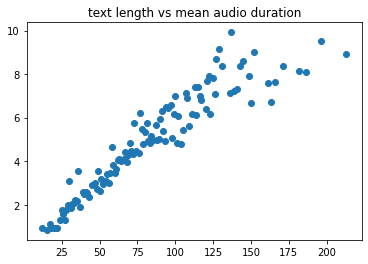

In [23]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

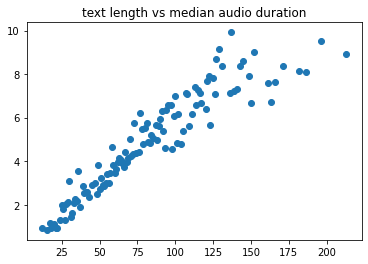

In [24]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

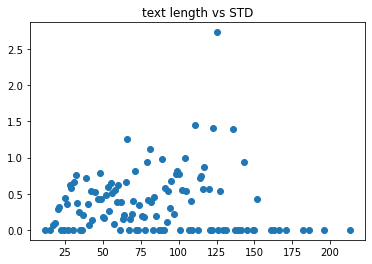

In [25]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

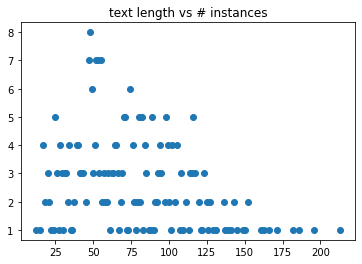

In [26]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [27]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [28]:
w_count_df

,0
di,157
che,77
non,75
il,74
la,74
...,...
attutite.,1
gridate,1
"rimprovero,",1
voci,1


In [29]:
# check a certain word
w_count_df.at['minute', 0]

KeyError: 'minute'

<AxesSubplot:>

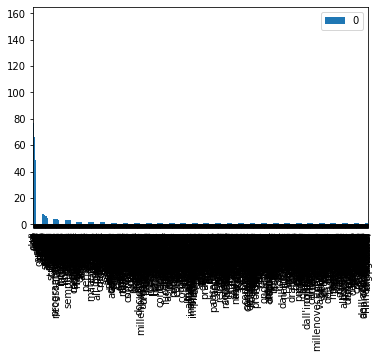

In [30]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()